In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torchvision.utils as tutils
import imageio
import pickle
import copy
from PIL import Image
import h5py 
from torch.utils.data import Dataset, DataLoader
from matplotlib.pyplot import imshow
import pandas as pd

/home/bhushan/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Helper routines
IS_CUDA = False
if torch.cuda.is_available():
    IS_CUDA = True
    
def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def generate_animation(root, epoch, name):
    images = []
    for e in range(epoch):
        img_name = root+'/image_'+str(e)+'.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root+ '/' + name +'.gif', images, fps=5)

def drawLossPlot(generatorLoss, discriminatorLoss, showPlot = False, savePlot = True, loc = ""):
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Vanilla GAN Loss')
    plt.plot(generatorLoss, label='Generator Loss')
    plt.plot(discriminatorLoss, label='Discriminator Loss')
    legend = plt.legend(loc='upper right', shadow=True)
    
    if showPlot:
        plt.show()
    if savePlot:
        plt.savefig(loc+'Loss_Plot_Vanilla_GAN_'+str(num_epochs)+'.png')

def save_image(pic, path):
    grid = torchvision.utils.make_grid(pic, nrow=8, padding=2)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

class LossModule: 
    def __init__(self):
        self.D_loss = []
        self.G_loss = []

    def insertDiscriminatorLoss(self, lossVal):
        self.D_loss.append(lossVal)
    
    def insertGeneratorLoss(self, lossVal):
        self.G_loss.append(lossVal)
    
    def getDiscriminatorLoss(self):
        return self.D_loss
    
    def getGeneratorLoss(self):
        return self.G_loss
    

In [3]:
class waspShadeRenderer(nn.Module):
    def __init__(self, opt):
        super(waspShadeRenderer, self).__init__()
        self.opt = opt
        self.getHomo = HomogeneousCoord(opt)
        self.getMMatrix = MMatrix(opt)
        
    def forward(self, light, normals):
        # homogeneous coordinate of the normals
        #normals = var(normals).type(torch.DoubleTensor)
        batchSize = normals.size(0)
        W = normals.size(2)
        H = normals.size(3)
        hNormals = self.getHomo(normals)
        # matrix for light
        mLight = self.getMMatrix(light)
        # get shading from these two: N x 4 , N = batchSize x W x H 
        hN_vec = hNormals.view(batchSize, 4, -1).permute(0,2,1).contiguous().view(-1,4)
        # N x 1 x 4
        hN_vec_Left  = hN_vec.unsqueeze(1)
        # N x 4 x 1
        hN_vec_Right = hN_vec.unsqueeze(2)
        # expand the lighting from batchSize x 4 x 4 to N x 4 x 4
        hL = mLight.view(batchSize,16).repeat(1,W*H).view(-1,4,4)
        shade0 = torch.matmul(hN_vec_Left, hL)
        shade1 = torch.matmul(shade0, hN_vec_Right)
        #shade1 is tensor of size Nx1x1 = batchSize x W x H
        shading = shade1.view(batchSize,W,H).unsqueeze(1) 
        return shading

class HomogeneousCoord(nn.Module):
    """docstring for getHomogeneousCoord"""
    def __init__(self, opt):
        super(HomogeneousCoord, self).__init__()
        self.opt = opt
    def forward(self, x):
        y = Variable(torch.DoubleTensor(x.size(0),1,x.size(2),x.size(3)).fill_(1),requires_grad=False)
        z = torch.cat((x,y),1)
        return z

class MMatrix(nn.Module):
    """docstring for getHomogeneousCoord"""
    def __init__(self, opt):
        super(MMatrix, self).__init__()
        self.opt = opt
    def forward(self, L):
        # input L:[batchSize,9]
        # output M: [batchSize, 4, 4]
        c1 = 0.429043
        c2 = 0.511664
        c3 = 0.743152
        c4 = 0.886227
        c5 = 0.247708
        M00 = c1*L[:,8].unsqueeze(1)
        M01 = c1*L[:,4].unsqueeze(1)
        M02 = c1*L[:,7].unsqueeze(1)
        M03 = c2*L[:,3].unsqueeze(1)
        M10 = c1*L[:,4].unsqueeze(1)
        M11 = -c1*L[:,8].unsqueeze(1)
        M12 = c1*L[:,5].unsqueeze(1)
        M13 = c2*L[:,1].unsqueeze(1)
        M20 = c1*L[:,7].unsqueeze(1)
        M21 = c1*L[:,5].unsqueeze(1)
        M22 = c3*L[:,6].unsqueeze(1)
        M23 = c2*L[:,2].unsqueeze(1)
        M30 = c2*L[:,3].unsqueeze(1)
        M31 = c2*L[:,1].unsqueeze(1)
        M32 = c2*L[:,2].unsqueeze(1)
        M33 = c4*L[:,0].unsqueeze(1) - c5*L[:,6].unsqueeze(1)
        M0 = torch.cat((M00,M01,M02,M03),dim=1).unsqueeze(1)
        M1 = torch.cat((M10,M11,M12,M13),dim=1).unsqueeze(1)
        M2 = torch.cat((M20,M21,M22,M23),dim=1).unsqueeze(1)
        M3 = torch.cat((M30,M31,M32,M33),dim=1).unsqueeze(1)
        M = torch.cat((M0,M1,M2,M3),dim=1)
        return M

In [4]:
# Test matlab generated H5 file
hf = h5py.File('../../Light-Estimation/datasets/realImagesSH/data_1.h5', 'r')
print hf.keys()
syn1 = hf['/Image']
lighting = hf['/Lighting']
normal = hf['/Normal']
height = hf['/Height']
reflectance = hf['/Reflectance']
finalLoss = hf['/FinalLoss']
shading = hf['/Shading']

[u'FinalLoss', u'Height', u'Image', u'Lighting', u'Normal', u'Reflectance', u'Shading']


In [38]:
print lighting.shape
print syn1.shape
print normal.shape
print height.shape
print reflectance.shape
print finalLoss.shape
print shading.shape
batch_size = 50
realImage = torch.utils.data.DataLoader(syn1, batch_size= batch_size, shuffle = False)
realSH = torch.utils.data.DataLoader(lighting, batch_size= batch_size, shuffle = False)
rNormal = torch.utils.data.DataLoader(normal, batch_size= batch_size, shuffle = False)
rHeight = torch.utils.data.DataLoader(height, batch_size= batch_size, shuffle = False)
rReflectance = torch.utils.data.DataLoader(reflectance, batch_size= batch_size, shuffle = False)
rFinalLoss = torch.utils.data.DataLoader(finalLoss, batch_size= batch_size, shuffle = False)
rShading = torch.utils.data.DataLoader(shading, batch_size= batch_size, shuffle = False)

(100, 27)
(100, 3, 64, 64)
(100, 3, 64, 64)
(100, 64, 64)
(100, 3, 64, 64)
(100,)
(100, 3, 64, 64)


torch.Size([50, 3, 64, 64])


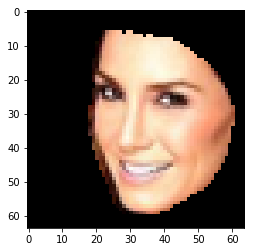

In [65]:
dreal = next(iter(realImage))
print dreal.shape
show(dreal[0])

torch.Size([50, 3, 64, 64])


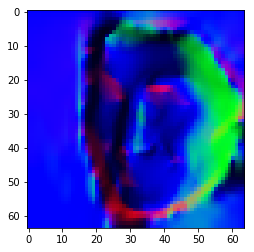

In [64]:
dreal = next(iter(rNormal))
print dreal.shape
show(denorm(dreal[0]))

In [41]:
# Shading from Normals and SH
def ShadingFromDataLoading(rNomal, SH):
    normal = next(iter(rNormal))
    normal = denorm(normal)
    normal = var(normal).type(torch.DoubleTensor)

    rSH = next(iter(SH))
    rSH = var(rSH).type(torch.DoubleTensor)
    return getShadingFromNormalAndSH(normal, rSH)

# 
def getShadingFromNormalAndSH(Normal, rSH):
    shader = waspShadeRenderer(None)
    out1 = shader(rSH, Normal)
    rSH = rSH[:,9:] #.unsqueeze(0)
    out2 = shader(rSH, Normal)
    rSH = rSH[:,9:] #.unsqueeze(0)
    out3 = shader(rSH, Normal)
    outShadingB = torch.cat((out1, out2, out3), 1)
    return outShadingB

In [42]:
# Test Shading
outShadingB = ShadingFromDataLoading(rNormal, realSH)
print outShadingB.shape
outShadingB = denorm(outShadingB)
outShadingB = outShadingB.data
outShading = np.transpose(outShadingB[0].numpy(), (1,2,0))

torch.Size([50, 3, 64, 64])


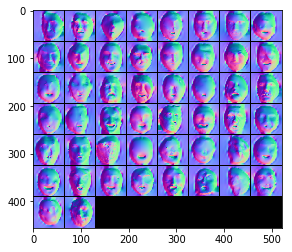

In [43]:
# Normal
rImg = denorm(dreal)
#rImg = dreal.data
show(torchvision.utils.make_grid(rImg, padding=1))

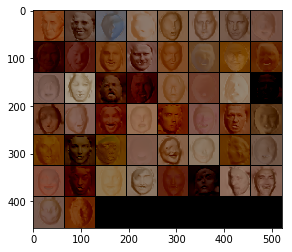

In [44]:
show(torchvision.utils.make_grid(outShadingB, padding=1))

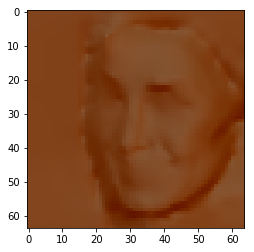

In [45]:
#show(denorm(out1[0]))
#OutSH = denorm(outShading)
plt.imshow(outShading,  interpolation='nearest')    

In [46]:
a = torch.rand((5, 27))
a.shape

torch.Size([5, 27])

In [47]:
b = a[:,9:]  #.unsqueeze(0)
#rSH = rSH[:][0][9:].unsqueeze(0)
b.shape

torch.Size([5, 18])

In [48]:
# Test output of Model
hf = h5py.File('./Normal_SH.h5', 'r')
print hf.keys()
Normal = hf['/Normal']
SH = hf['/SH']

[u'Normal', u'SH']


In [49]:
rNomal = torch.utils.data.DataLoader(Normal, batch_size= batch_size, shuffle = False)
rSH = torch.utils.data.DataLoader(SH, batch_size= batch_size, shuffle = False)

In [50]:
imageOut = ShadingFromDataLoading(rNormal, rSH)

In [51]:
imageOut = denorm(imageOut)
imageOut = imageOut.data
imageOut1 = np.transpose(imageOut[0].numpy(), (1,2,0))

torch.Size([50, 3, 64, 64])


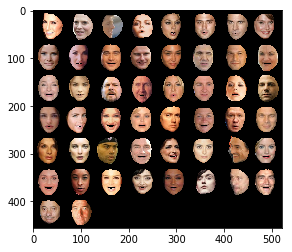

In [62]:
dreal = next(iter(realImage))
print dreal.shape
show(denorm(dreal[0]))
show(torchvision.utils.make_grid(dreal, padding=1))

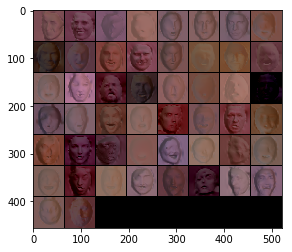

In [52]:
show(torchvision.utils.make_grid(imageOut, padding=1))

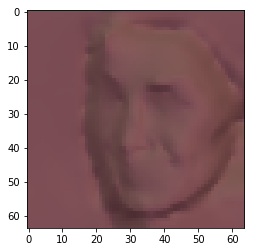

In [53]:
plt.imshow(imageOut1,  interpolation='nearest')

In [60]:
print next(iter(realSH))[0]


-0.2070
-0.0721
 0.3386
-0.2819
-0.0146
 0.0883
-0.1537
 0.1932
-0.1623
-0.6462
-0.1838
 0.4290
-0.5842
 0.0648
 0.0845
-0.1420
 0.1970
-0.1338
-0.9759
-0.2434
 0.4910
-0.6991
 0.0885
 0.0692
-0.1315
 0.2057
-0.1131
[torch.DoubleTensor of size 27]



In [59]:
print next(iter(rSH))[0]


-0.3252
-0.0459
 0.3972
-0.3992
-0.0289
 0.1632
-0.0944
 0.1746
-0.1457
-0.5645
-0.1044
 0.3453
-0.3936
 0.1038
 0.0896
-0.1641
 0.0855
-0.0771
-0.6523
-0.0747
 0.4003
-0.3067
 0.0604
 0.0453
-0.0995
 0.1099
-0.0698
[torch.FloatTensor of size 27]

